# PSI Numerical Methods 2025 - Homework #1 - Sparse matrices and interpolation -  Jan 24

For this homework, you will investigate _cubic splines_, a common method for interpolating a function
between samples.  You will investigate using sparse matrices in Julia and see how they perform (in terms of compute time).

## Cubic splines

Cubic splines are a method for _interpolating_ between data points.  Unlike in class, here we are going to assume
the data points are _perfect_, so we want the interpolating curve to go exactly through each data point.  We also
want the curve to be smooth.

A cubic spline is a piecewise polynomial (cubic) function.  If we have data points $(x_0,y_0), (x_1, y_1), ..., (x_N, y_N)$, then there is one
function $C_1(x)$ that is used for all values of $x$ between $x_0$ and $x_1$, and another function $C_2(x)$ for $x$ values
between $x_1$ and $x_2$, and so on -- so we have $N$ cubic functions in total (and $N+1$ data points!).

I am using the notation from this web page: https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation
which you can use as a reference.

The cubic spline is also defined to be second-order continuous.  Consider the value $x_1$.  For $x$ values slightly less than $x_1$, the
spline is evaluated using function $C_1(x)$, and for $x$ values slightly above $x_1$, function $C_2(x)$ is used.  We want the spline to
go through the data points, so we want $C_1(x_1) = y_1$, and also $C_2(x_1) = y_1$.  We want the spline to be smooth, that is, for the
derivatives to be equal when we switch from one function to the next at the data points, so $C_1'(x_1) = C_2'(x_1)$, and also for the second derivatives to be equal at the data points: $C_1''(x_1) = C_2''(x_1)$.

Finally, at the endpoints, there are different options, but we'll use the _natural_ boundary conditions, $C_1''(x_0) = C_N''(x_N) = 0$.

Julia has a package for splines (probably many of them); let's have a quick look just to see what the spline function looks like;
we're going to create our own splines from scratch, next.

In [1]:
using Pkg
Pkg.add("Interpolations")

    Updating registry at `C:\Users\shjsf\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\shjsf\.julia\environments\v1.11\Project.toml`
  [a98d9a8b] + Interpolations v0.15.1
  No Changes to `C:\Users\shjsf\.julia\environments\v1.11\Manifest.toml`


In [3]:
using WGLMakie
using Interpolations
using CairoMakie

In [4]:
# Let's create the data set of xx,yy -- I'll use y = sin(x) as an example.
min_x = 0.01
max_x = 7.
xx = range(min_x, max_x, 10)
yy = sin.(xx);

In [5]:
# This is the weird syntax of this "Interpolations" package for a cubic spline, on a grid, with natural boundaries...
spl = interpolate(yy, BSpline(Cubic(Natural(OnGrid()))))
spl = scale(spl, xx);

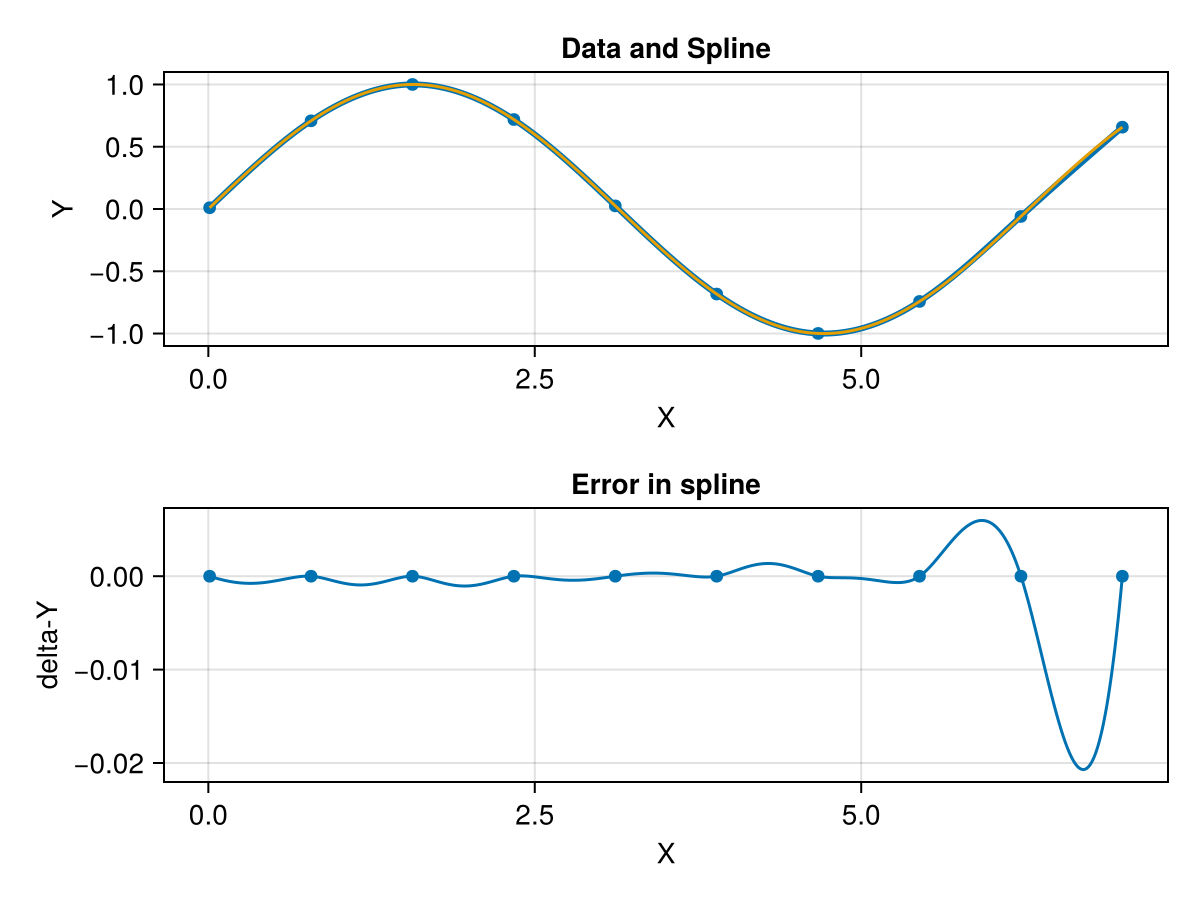

In [6]:
f = Figure()
Axis(f[1,1], title="Data and Spline", xlabel="X", ylabel="Y")
scatter!(xx, yy)
plotx = range(min_x, max_x, 1000)
lines!(plotx, spl(plotx), linewidth=3)
lines!(plotx, sin.(plotx))
Axis(f[2,1], title="Error in spline", xlabel="X", ylabel="delta-Y")
lines!(plotx, spl(plotx) .- sin.(plotx))
scatter!(xx, zeros(length(xx)))
f

We can see that the spline interpolates between the data points -- the error at each data point is exactly zero -- and it does a pretty good job of fitting the whole curve.  Depending on the range of $x$ values you
choose, the errors at the endpoints will be better or worse -- because we're forcing the second derivatives to be zero at the endpoints.

If we want to create our own spline function, we need to find the coefficients of all $N$ of the cubic polynomial functions $C_1$ to $C_N$.

To do this, we will set up and solve a matrix equation.  In this case, we're going to have $4 N$ polynomial coefficients to solve for, and $4 N$ constraints, so this will be a square matrix of size $4N$ by $4N$ and we will get an exact solution.

Each constraint will be a _row_ in the matrix and the right-hand-side vector.

Let's name the coefficients: $C_i(x) = a_i + b_i x + c_i x^2 + d_i x^3$.

We will build the matrix $A$, we will solve for a vector of coefficients, let's call it $c$, and the right-hand-side vector will be $r$.

The vector $c$ will have elements $c = [a_1, b_1, c_1, d_1, a_2, b_2, c_2, d_2, ..., a_N, b_N, c_N, d_N]'$.

Now, we want each function $C_i(x)$ to interpolate the two endpoints that bound it: $C_i(x_{i-1}) = y_{i-1}$ and $C_i(x_i) = y_i$.
That gives us two constraints -- two rows in the matrix -- for each of the $N$ functions.

For example, the first constraint, $C_1(x_0) = y_0$ gives us a row like:

$A c = r$

```
[  1  x_0  x_0^2  x_0^3  0  0  0  0  .... ]   [ a_1 ]      [  y_0 ]
[                                         ]   [ b_1 ]      [      ]
[                                         ]   [ c_1 ]  =   [      ]
[                                         ]   [ d_1 ]      [      ]
[                                         ]   [ a_2 ]      [      ]
[                 ...                     ]   [ ... ]      [      ]
```

To make the derivatives at the endpoints equal, you will need to take the derivative of the functions $C_i(x)$ and $C_{i+1}(x)$
and set their difference equal to zero at $x_i$.  For example,
$C_1'(x_1) - C_2'(x_1) = 0$, so that constraint will involve both the coefficients $a_1, b_1, c_1, d_1$ _and_ $a_2, b_2, c_2, d_2$.

Now start building your $A$ matrix!

In [7]:
# Our data points go from x_0 to x_N, so N is actually one less than the number of data points in xx!!

# With Julia's 1-based indexing, things are going to be a bit messy, because x_0 is actually in xx[1] !!

N = length(xx) - 1
A = zeros((4*N, 4*N))
r = zeros(4*N);

In [8]:
# .... YOUR CODE HERE to fill in elements of the A matrix

# This is tricky... it took me more than a few tries to get it right!

# You'll definitely want to write out the equations for each of the constraints (on paper)
# before trying to write the code here.

# Note that the coefficient will be laid out so that, in the matrix A,
#   terms that multiply a_i will be in column 4*(i-1) + 1
#                       b_i                   4*(i-1) + 2
#                       c_i                   4*(i-1) + 3
#                       d_i                   4*(i-1) + 4
# and if you need to refer to the coefficients for i+1, those will be in
#                       a_{i+1}               4*(i-1) + 5
#                       b_{i+1}               4*(i-1) + 6
#                       c_{i+1}               4*(i-1) + 7
#                       d_{i+1}               4*(i-1) + 8

# Left endpoint constraints: C_i(x_{i-1}) = y_{i-1}
# Put these in the first N rows...
for i in 1:N
   A[i, (4*(i-1))+1] = 1
   A[i, (4*(i-1))+2] = xx[i]
   A[i, (4*(i-1))+3] = xx[i]^2
   A[i, (4*(i-1))+4] = xx[i]^3
   r[i] = yy[i]
end

# Right endpoint constraints: C_i(x_i) = y_i
# Put these in the next N rows, N+1 to 2*N
for i in 1:N
   A[N + i, (4*(i-1))+1] = 1
   A[N + i, (4*(i-1))+2] = xx[i+1]
   A[N + i, (4*(i-1))+3] = xx[i+1]^2
   A[N + i, (4*(i-1))+4] = xx[i+1]^3
   r[N + i] = yy[i+1]
end

# First derivative constraints: C_i'(x_i) = C_{i+1}'(x_i)
# (note that this only goes up to N-1)
for i in 1:N-1
   A[2*N + i, (4*(i-1))+1] = 0
   A[2*N + i, (4*(i-1))+2] = -1
   A[2*N + i, (4*(i-1))+3] = -2*xx[i+1]
   A[2*N + i, (4*(i-1))+4] = -3*xx[i+1]^2
   A[2*N + i, (4*(i-1))+5] = 0
   A[2*N + i, (4*(i-1))+6] = 1
   A[2*N + i, (4*(i-1))+7] = 2*xx[i+1]
   A[2*N + i, (4*(i-1))+8] = 3*xx[i+1]^2
   r[2*N + i] = 0
end

# Second derivative constraints: C_i''(x_i) = C_{i+1}''(x_i)
for i in 1:N-1
   A[3*N + i, (4*(i-1))+1] = 0
   A[3*N + i, (4*(i-1))+2] = 0
   A[3*N + i, (4*(i-1))+3] = -2
   A[3*N + i, (4*(i-1))+4] = -6*xx[i+1]
   A[3*N + i, (4*(i-1))+5] = 0
   A[3*N + i, (4*(i-1))+6] = 0
   A[3*N + i, (4*(i-1))+7] = 2
   A[3*N + i, (4*(i-1))+8] = 6*xx[i+1]
   r[3*N + i] = 0
end

# Natural constraints for the leftmost and rightmost data point...
# You can put these in rows 3*N and 4*N, because those aren't filled in yet!
A[3*N, 3] = 2
A[3*N, 4] = 6*xx[1]
A[4*N, 4*N-1] = 2
A[4*N, 4*N] = 6*xx[N+1];

In [9]:
# Now we get our coefficient vector by solving the matrix equation:
c = A \ r;

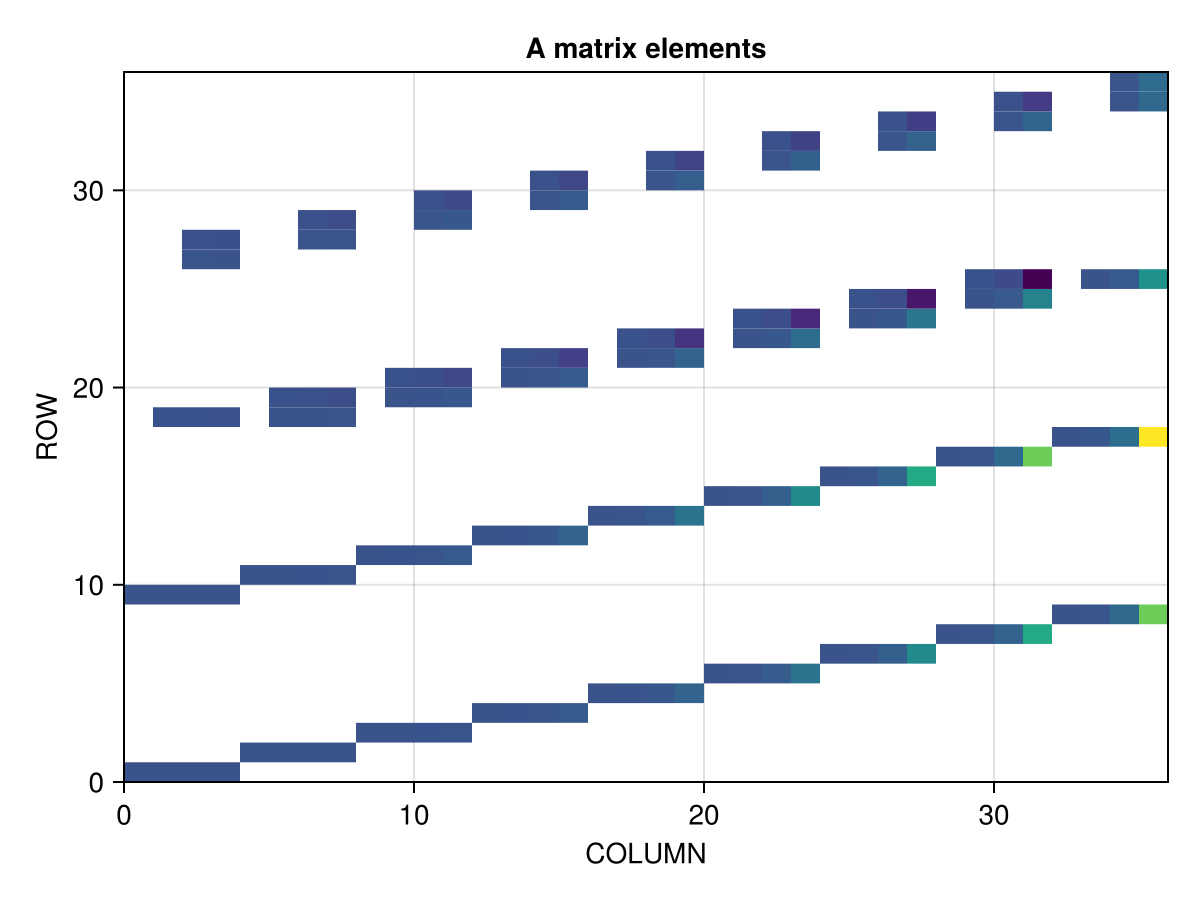

In [10]:
# One useful feature for debugging is the spy() function -- this shows you which elements of a matrix are
# non-zero.
f = Figure()
Axis(f[1,1], title="A matrix elements", ylabel="ROW", xlabel="COLUMN")
spy!(A')
f

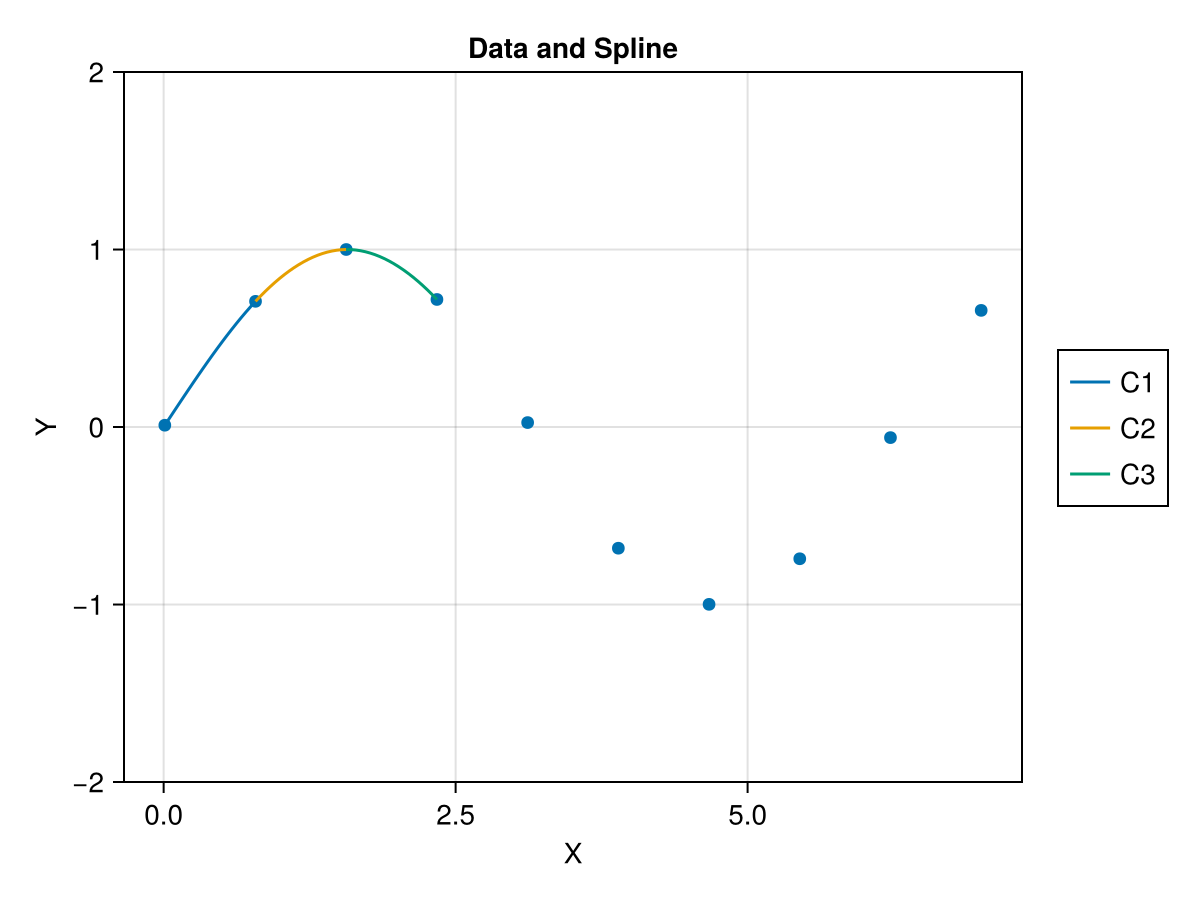

In [11]:
# For debugging, you might find it helpful to plot the first few function C_1, C_2, C_3. 

f = Figure()
ax = Axis(f[1,1], title="Data and Spline", xlabel="X", ylabel="Y")
scatter!(xx, yy)
plotx = range(min_x, max_x, 1000)

C1 = x -> @. c[1] + c[2]  * x + c[3]  * x^2 + c[4]  * x^3
C2 = x -> @. c[5] + c[6]  * x + c[7]  * x^2 + c[8]  * x^3
C3 = x -> @. c[9] + c[10] * x + c[11] * x^2 + c[12] * x^3
margin = 0
lines!(range(xx[1]-margin, xx[2]+margin, 20), C1, label="C1")
lines!(range(xx[2]-margin, xx[3]+margin, 20), C2, label="C2")
lines!(range(xx[3]-margin, xx[4]+margin, 20), C3, label="C3")
ylims!(-2, +2)
f[1,2] = Legend(f, ax)
f

In [12]:
# Here's one way we can create a single function to evaluate the spline:
# This is a function that creates and returns another function!
function make_spline(xgrid, coeffs)
    # Here's the spline function we're creating...
    function spline_function(x)
        N = length(xgrid)-1
        for i in 1:N
            # Is this the right segment?
            if (x < xgrid[i+1]) || (i == N)
                # Evaluate the cubic polynomial for this segment!
                i0 = 4*(i-1)
                return coeffs[i0 + 1] + coeffs[i0 + 2] * x + coeffs[i0 + 3] * x^2 + coeffs[i0 + 4] * x^3
            end
        end
    end
    # We can use the "map" function so that a scalar input produces a scalar output,
    # and a vector input produces a vector output
    function vectorized_spline_function(x)
        return map(spline_function, x)
    end
    return vectorized_spline_function
end;

In [13]:
spline = make_spline(xx, c);

In [14]:
spline(5.)

-0.9591720257389236

In [15]:
spline([5., 6.])

2-element Vector{Float64}:
 -0.9591720257389236
 -0.27377044850368293

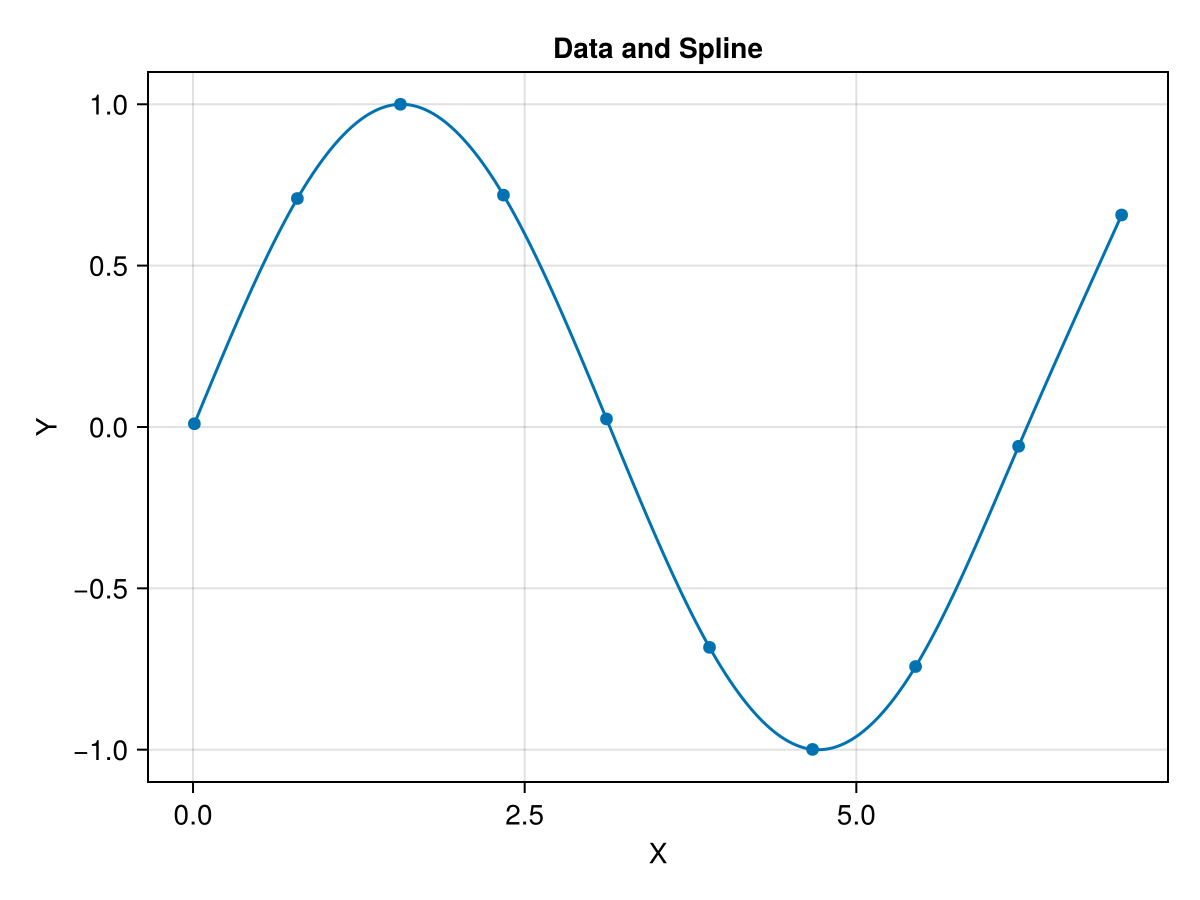

In [16]:
# Now go ahead and plot your resulting spline!
f = Figure()
ax = Axis(f[1,1], title="Data and Spline", xlabel="X", ylabel="Y")
scatter!(xx, yy)
plotx = range(min_x, max_x, 1000)
lines!(plotx, spline)
f

If you got that working -- congratulations!!

## Timing your code

Next we're going to look at how much compute time the spline method takes, and how we can speed that up.

To do that, you're going to have to take all your code above -- for creating and solving the $A$ matrix -- and put it inside
a function where we can pass in the $xx$ and $yy$ values that we want to fit.

In [17]:
function get_spline_coefficients(xx, yy)
    N = length(xx) - 1
    A = zeros((4*N, 4*N))
    r = zeros(4*N)
    # Left endpoint constraints: C_i(x_{i-1}) = y_{i-1}
    # Put these in the first N rows...
    for i in 1:N
    A[i, (4*(i-1))+1] = 1
    A[i, (4*(i-1))+2] = xx[i]
    A[i, (4*(i-1))+3] = xx[i]^2
    A[i, (4*(i-1))+4] = xx[i]^3
    r[i] = yy[i]
    end

    # Right endpoint constraints: C_i(x_i) = y_i
    # Put these in the next N rows, N+1 to 2*N
    for i in 1:N
    A[N + i, (4*(i-1))+1] = 1
    A[N + i, (4*(i-1))+2] = xx[i+1]
    A[N + i, (4*(i-1))+3] = xx[i+1]^2
    A[N + i, (4*(i-1))+4] = xx[i+1]^3
    r[N + i] = yy[i+1]
    end

    # First derivative constraints: C_i'(x_i) = C_{i+1}'(x_i)
    # (note that this only goes up to N-1)
    for i in 1:N-1
    A[2*N + i, (4*(i-1))+1] = 0
    A[2*N + i, (4*(i-1))+2] = -1
    A[2*N + i, (4*(i-1))+3] = -2*xx[i+1]
    A[2*N + i, (4*(i-1))+4] = -3*xx[i+1]^2
    A[2*N + i, (4*(i-1))+5] = 0
    A[2*N + i, (4*(i-1))+6] = 1
    A[2*N + i, (4*(i-1))+7] = 2*xx[i+1]
    A[2*N + i, (4*(i-1))+8] = 3*xx[i+1]^2
    r[2*N + i] = 0
    end

    # Second derivative constraints: C_i''(x_i) = C_{i+1}''(x_i)
    for i in 1:N-1
    A[3*N + i, (4*(i-1))+1] = 0
    A[3*N + i, (4*(i-1))+2] = 0
    A[3*N + i, (4*(i-1))+3] = -2
    A[3*N + i, (4*(i-1))+4] = -6*xx[i+1]
    A[3*N + i, (4*(i-1))+5] = 0
    A[3*N + i, (4*(i-1))+6] = 0
    A[3*N + i, (4*(i-1))+7] = 2
    A[3*N + i, (4*(i-1))+8] = 6*xx[i+1]
    r[3*N + i] = 0
    end

    # Natural constraints for the leftmost and rightmost data point...
    # You can put these in rows 3*N and 4*N, because those aren't filled in yet!
    A[3*N, 3] = 2
    A[3*N, 4] = 6*xx[1]
    A[4*N, 4*N-1] = 2
    A[4*N, 4*N] = 6*xx[N+1];
    c = A \ r
    return c
end;

In [18]:
# Now, for Complicated Reasons, Julia can sometimes make bad decisions about how many CPU cores or threads to use.
# Turn that off for simplicity in measuring our timing.
using LinearAlgebra
LinearAlgebra.BLAS.set_num_threads(1)

Now we can use the @elapsed magic function to time how long in seconds our function takes.

In [19]:
t = @elapsed get_spline_coefficients(xx, yy)
t

0.1098278

Now let's run our spline function on larger and larger problems (more and more $xx$, $yy$ points),
and time how long each one takes.

In [37]:
# This range of matrix sizes worked okay for me (the largest one took ~5 seconds),
# but feel free to change it if it's taking too long!
sizes = range(100, 2000, 20)
times = Vector{Float64}()
for s in sizes
    s = Int(floor(s))
    xx = range(min_x, max_x, s)
    yy = sin.(xx)
    t = @elapsed get_spline_coefficients(xx, yy)
    println("Size $s, time $t")
    push!(times, t)
end

Size 100, time 0.0120403
Size 200, time 0.0124576
Size 300, time 0.0308672
Size 400, time 0.0703219
Size 500, time 0.1283851
Size 600, time 0.21025
Size 700, time 0.3299064
Size 800, time 0.5120449
Size 900, time 0.6853855
Size 1000, time 0.9582179
Size 1100, time 1.1722343
Size 1200, time 1.5381421
Size 1300, time 1.9343972
Size 1400, time 2.3921075
Size 1500, time 3.0274027
Size 1600, time 3.652385
Size 1700, time 4.1475283
Size 1800, time 5.036881
Size 1900, time 5.9535355
Size 2000, time 6.7678618


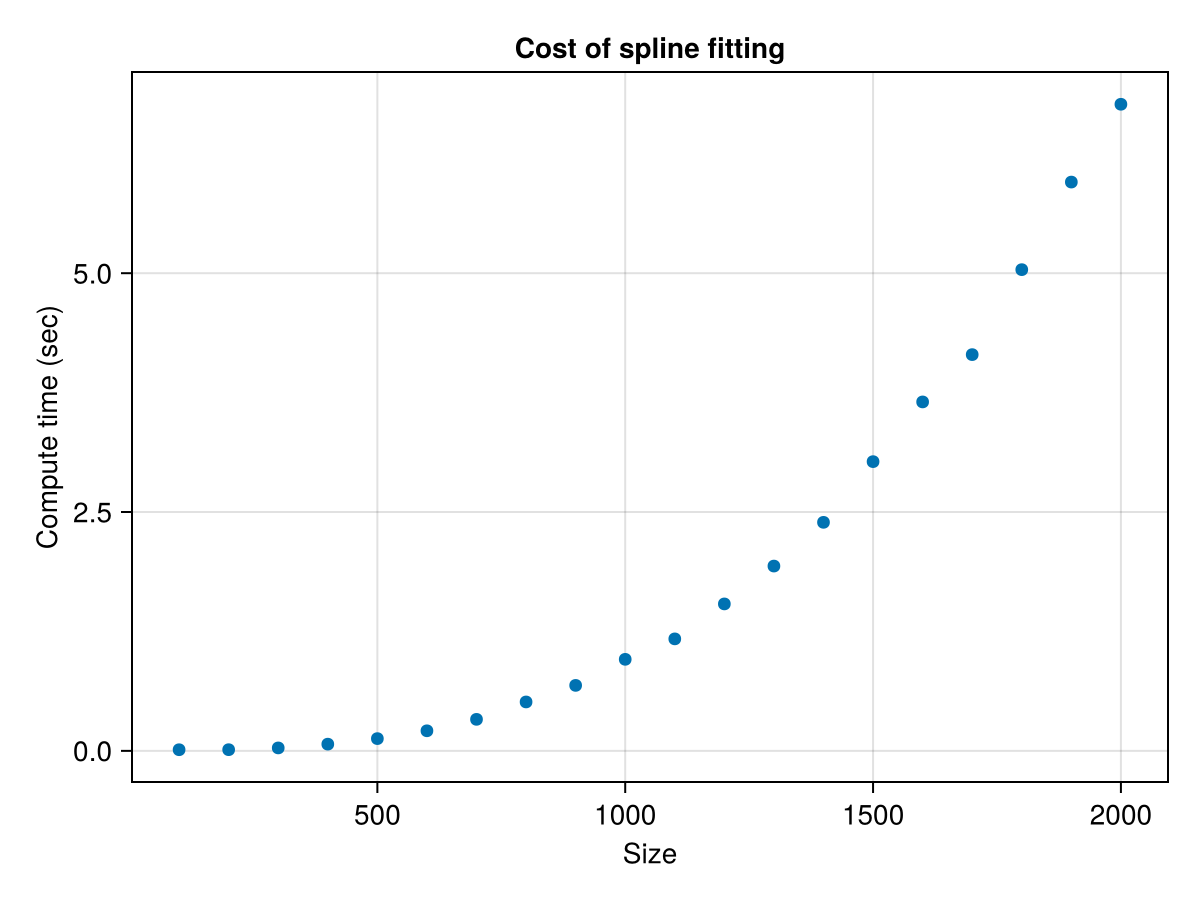

In [38]:
f = Figure()
ax = Axis(f[1,1], title="Cost of spline fitting", xlabel="Size", ylabel="Compute time (sec)")
# You can make the plot a log-log plot by adding this to the "Axis" call:   yscale=log10, xscale=log10
scatter!(sizes, times)
f

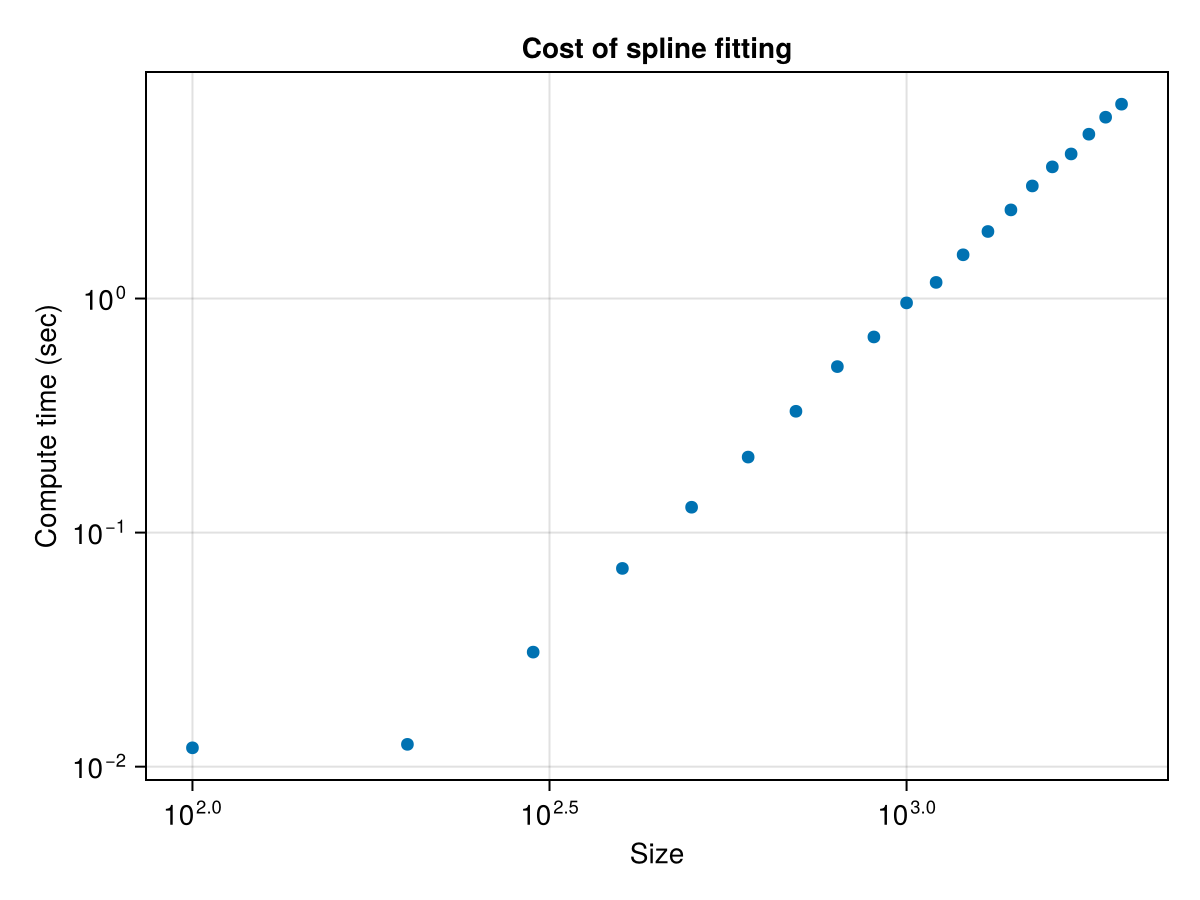

In [39]:
f = Figure()
ax = Axis(f[1,1], title="Cost of spline fitting", xlabel="Size", ylabel="Compute time (sec)",yscale=log10, xscale=log10)
# You can make the plot a log-log plot by adding this to the "Axis" call:   yscale=log10, xscale=log10
scatter!(sizes, times)
f

What do you notice about how long the code takes to run as the problem gets larger?  Does it grow linearly?
Faster than linearly?  Why do you think that might be?  What is the expensive step in your function?
If it looks like the compute time is growing as a power of the problem size, can you figure out what the power is?

The time expense increases faster than linearity. This is because solving the inverse of A is a O(n^2) step. See below for the illustration.

In [22]:
function inverse(r)
    A = rand(length(r),length(r))
    return A\r
end

inverse (generic function with 1 method)

In [40]:
# generate a matrix A of s*s, and vector of s, and solve A\r

ssizes = range(100, 2000, 20)
ttimes = Vector{Float64}()
for s in ssizes
    s = Int(floor(s))
    r = rand(s)
    t = @elapsed inverse(r)
    println("Size $s, time $t")
    push!(ttimes, t)
end

Size 100, time 0.0005842
Size 200, time 0.0009441
Size 300, time 0.0018513
Size 400, time 0.0022438
Size 500, time 0.0038873
Size 600, time 0.0058482
Size 700, time 0.0088605
Size 800, time 0.0120709
Size 900, time 0.1555226
Size 1000, time 0.0262853
Size 1100, time 0.0342418
Size 1200, time 0.0453508
Size 1300, time 0.0514798
Size 1400, time 0.0591942
Size 1500, time 0.0671731
Size 1600, time 0.0826898
Size 1700, time 0.090503
Size 1800, time 0.1054179
Size 1900, time 0.1375408
Size 2000, time 0.1444839


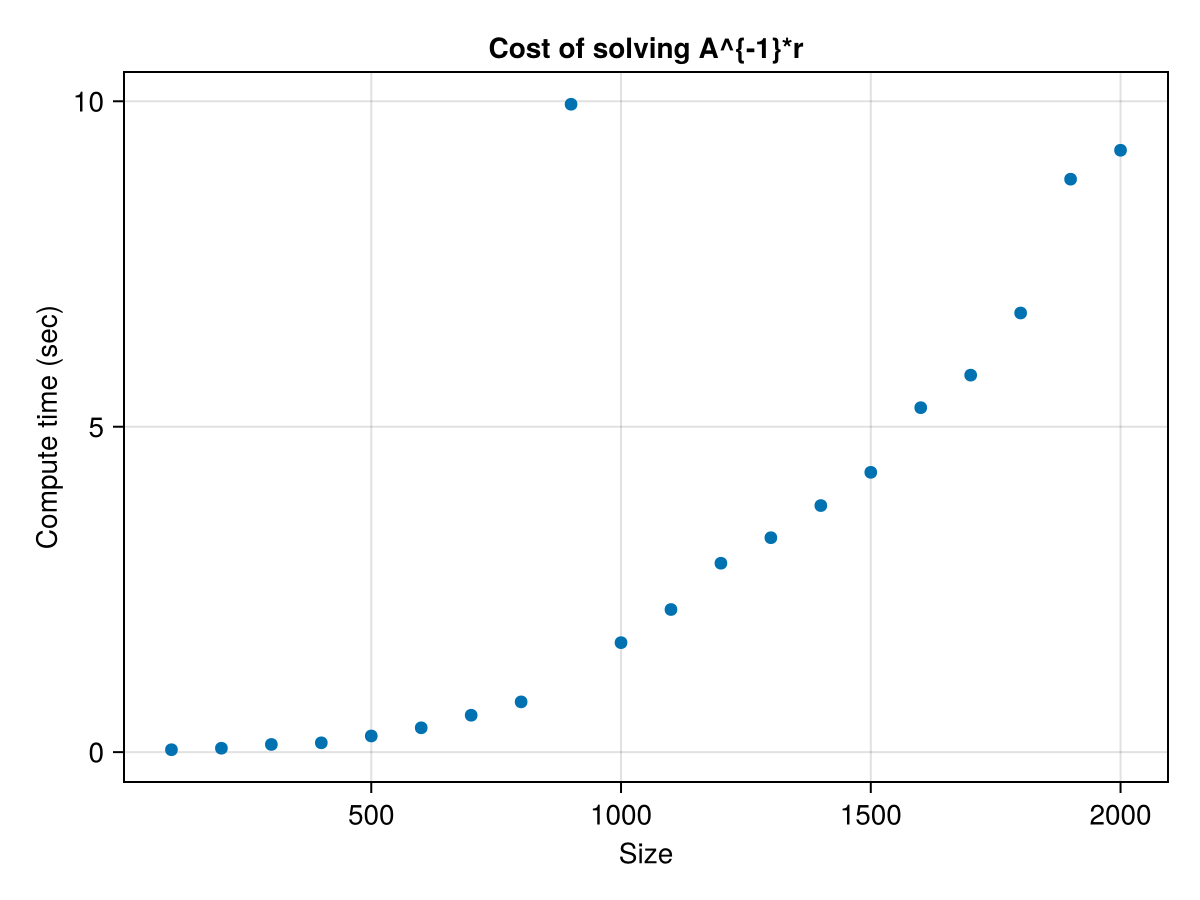

In [53]:
f = Figure()
ax = Axis(f[1,1], title="Cost of solving A^{-1}*r", xlabel="Size", ylabel="Compute time (sec)")
# You can make the plot a log-log plot by adding this to the "Axis" call:   yscale=log10, xscale=log10
scatter!(ssizes, ttimes*4*4*4)
f
#Plot the time cost of A\r

## Sparse Matrices

If you look at your $A$ matrix using that $spy(A')$ plot, you will see that the matrix is quite sparse -- each constraint only involves a few of the coefficients, so this matrix will be mostly zeros.

We can tell Julia that we have a sparse matrix by building our matrix differently.  Instead of creating a matrix full of zeros and
setting the elements we want, we will instead create a list of the rows and columns that we want to fill, with their values.

In [1]:
using SparseArrays

In [2]:
# You can create a sparse matrix by passing in the ROWS, COLUMNS, and VALUES:
rows = [1, 1, 2, 3]
cols = [1, 3, 2, 3]
values = [7., 100., 23., 49.]
A = sparse(rows, cols, values)

3×3 SparseMatrixCSC{Float64, Int64} with 4 stored entries:
 7.0    ⋅   100.0
  ⋅   23.0     ⋅ 
  ⋅     ⋅    49.0

Now create a new version of your `get_spline_coefficients` function that creates and solves a sparse matrix!

In [27]:
function get_spline_coefficients_sparse(xx, yy)
    N = length(xx) - 1
    r = zeros(4*N)
    
    A_rows = Vector{Int}()
    A_cols = Vector{Int}()
    A_vals = Vector{Float64}()

    for i in 1:N
        push!(A_rows,i)
        push!(A_cols,(4*(i-1))+1)
        push!(A_vals,1)
        push!(A_rows,i)
        push!(A_cols,(4*(i-1))+2)
        push!(A_vals,xx[i])
        push!(A_rows,i)
        push!(A_cols,(4*(i-1))+3)
        push!(A_vals,xx[i]^2)
        push!(A_rows,i)
        push!(A_cols,(4*(i-1))+4)
        push!(A_vals,xx[i]^3)
        r[i] = yy[i]
    end

    for i in 1:N
        push!(A_rows,N + i)
        push!(A_cols,(4*(i-1))+1)
        push!(A_vals,1)
        push!(A_rows,N + i)
        push!(A_cols,(4*(i-1))+2)
        push!(A_vals,xx[i+1])
        push!(A_rows,N + i)
        push!(A_cols,(4*(i-1))+3)
        push!(A_vals,xx[i+1]^2)
        push!(A_rows,N + i)
        push!(A_cols,(4*(i-1))+4)
        push!(A_vals,xx[i+1]^3)
        r[N + i] = yy[i+1]
    end

    for i in 1:N-1
        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+2)
        push!(A_vals,-1)
        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+3)
        push!(A_vals,-2*xx[i+1])
        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+4)
        push!(A_vals,-3*xx[i+1]^2)

        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+6)
        push!(A_vals,1)
        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+7)
        push!(A_vals,2*xx[i+1])
        push!(A_rows,2*N+i)
        push!(A_cols,(4*(i-1))+8)
        push!(A_vals,3*xx[i+1]^2)
    end

    for i in 1:N-1
        push!(A_rows,3*N+i)
        push!(A_cols,(4*(i-1))+3)
        push!(A_vals,-2)
        push!(A_rows,3*N+i)
        push!(A_cols,(4*(i-1))+4)
        push!(A_vals,-6*xx[i+1])

        push!(A_rows,3*N+i)
        push!(A_cols,(4*(i-1))+7)
        push!(A_vals,2)
        push!(A_rows,3*N+i)
        push!(A_cols,(4*(i-1))+8)
        push!(A_vals,6*xx[i+1])
    end

    push!(A_rows,3*N)
    push!(A_cols,3)
    push!(A_vals,2)
    push!(A_rows,3*N)
    push!(A_cols,4)
    push!(A_vals,6*xx[1])

    push!(A_rows,4*N)
    push!(A_cols,4*N-1)
    push!(A_vals,2)
    push!(A_rows,4*N)
    push!(A_cols,4*N)
    push!(A_vals,6*xx[N+1])
    ### FILL IN THE A MATRIX HERE!
    #
    # If you used to have
    #     A[i, j] = k
    #
    # You'll now write
    #    push!(A_rows, i)
    #    push!(A_cols, j)
    #    push!(A_vals, k)
    #
    # so every line of your code before becomes three lines now -- this function will be long!
    #
    
    A = sparse(A_rows, A_cols, A_vals)
    c = A \ r
    return c
end

get_spline_coefficients_sparse (generic function with 1 method)

After you have finished writing this, you should probably check that it gives you the same results!

In [28]:
c_sparse = get_spline_coefficients_sparse(xx, yy)
spline_sparse = make_spline(xx, c_sparse);

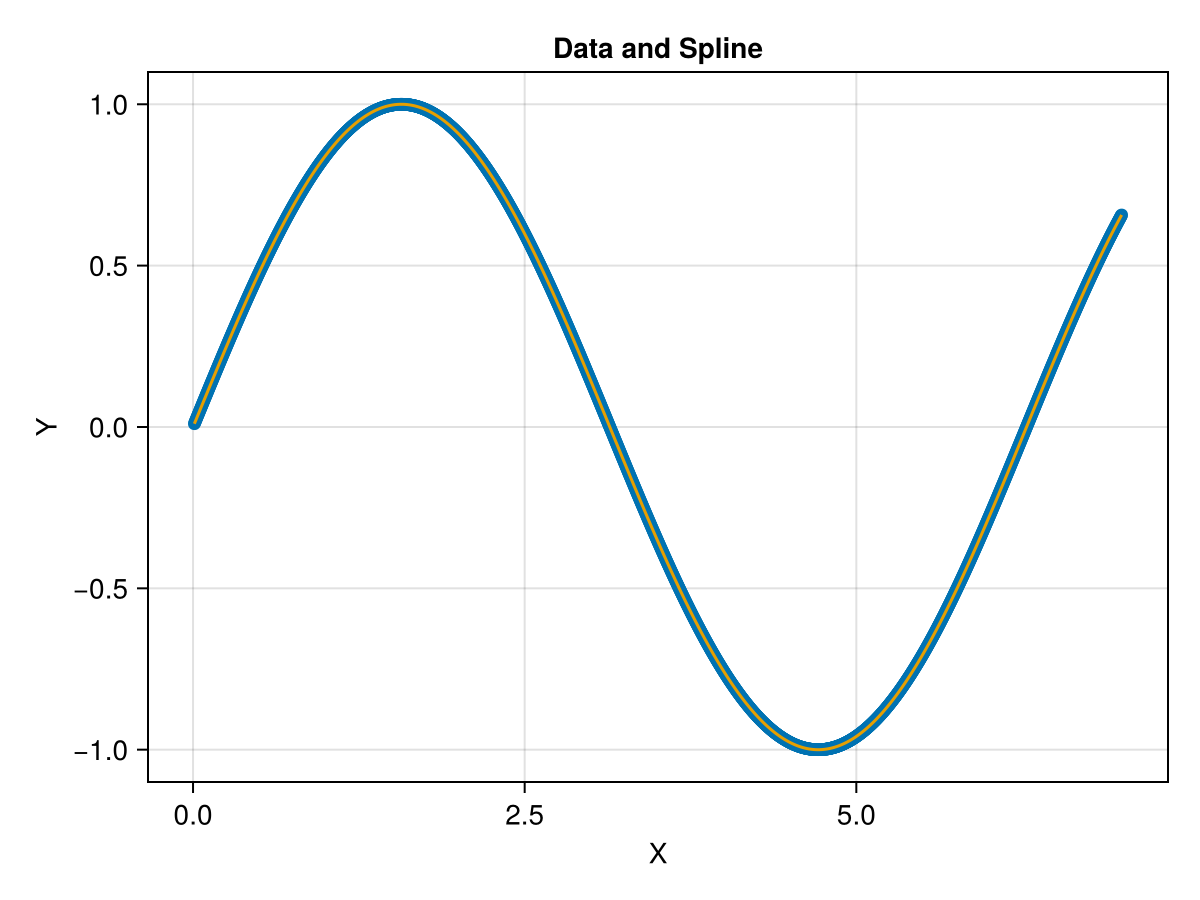

In [29]:
# Now go ahead and plot your resulting spline!
f = Figure()
ax = Axis(f[1,1], title="Data and Spline", xlabel="X", ylabel="Y")
scatter!(xx, yy)
plotx = range(min_x, max_x, 1000)
lines!(plotx, spline, linewidth=3)
lines!(plotx, spline_sparse)
f

Now let's time your sparse version!

In [42]:
sparse_sizes = range(100, 2000, 20)
sparse_times = Vector{Float64}()
for s in sparse_sizes
    s = Int(floor(s))
    xx = range(min_x, max_x, s)
    yy = sin.(xx)
    t = @elapsed get_spline_coefficients_sparse(xx, yy)
    println("Size $s, time $t")
    push!(sparse_times, t)
end

Size 100, time 0.0008467
Size 200, time 0.0055917
Size 300, time 0.0015796
Size 400, time 0.0018994
Size 500, time 0.0018122
Size 600, time 0.0042619
Size 700, time 0.0023535
Size 800, time 0.0038943
Size 900, time 0.0051336
Size 1000, time 0.0061462
Size 1100, time 0.0045566
Size 1200, time 0.0064977
Size 1300, time 0.0069314
Size 1400, time 0.0074297
Size 1500, time 0.0087146
Size 1600, time 0.0093195
Size 1700, time 0.0121073
Size 1800, time 0.0109305
Size 1900, time 0.0117871
Size 2000, time 0.0104655


And now compare the timings with the dense version!

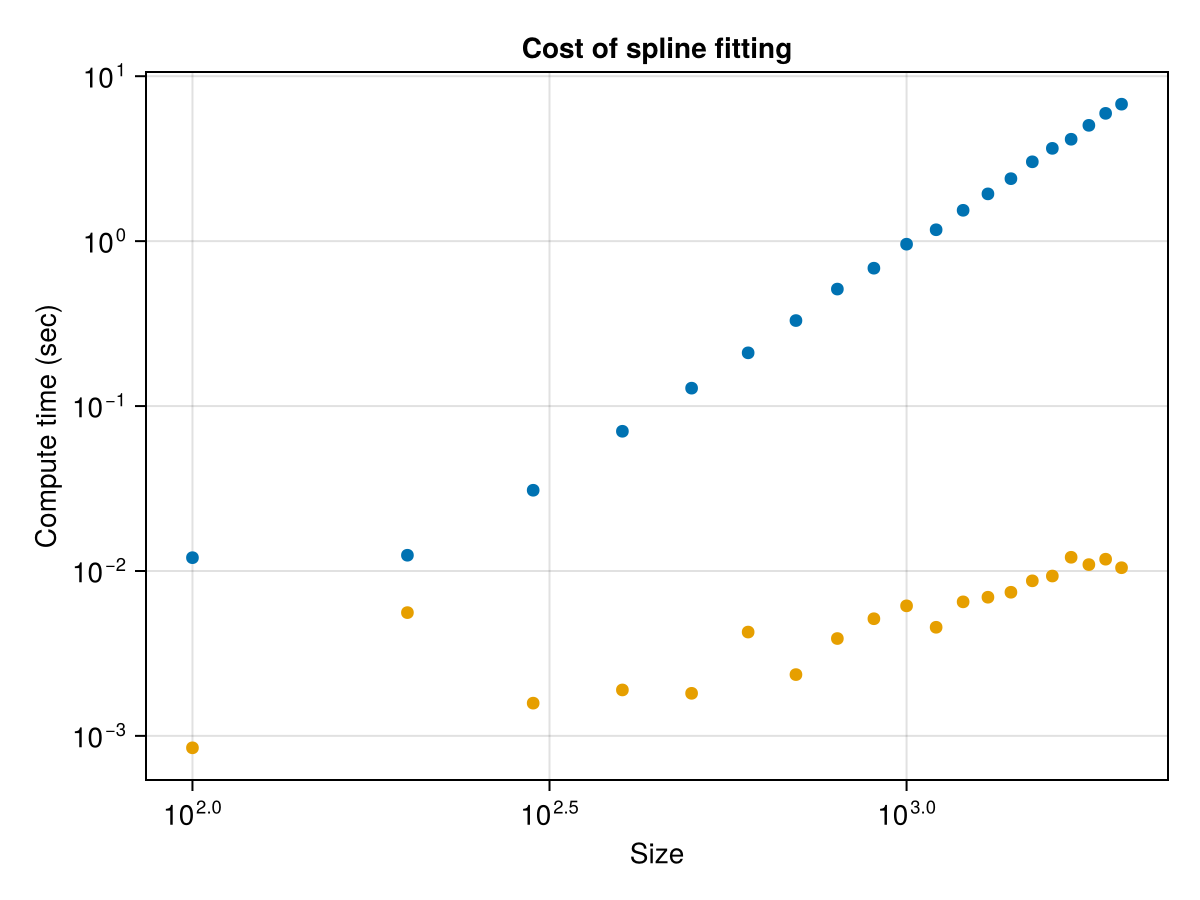

In [44]:
f = Figure()
ax = Axis(f[1,1], title="Cost of spline fitting", xlabel="Size", ylabel="Compute time (sec)",
        yscale=log10,xscale=log10)
scatter!(sizes, times)
scatter!(sparse_sizes, sparse_times)
f

In [51]:
sparse_sizes = range(1000, 9000, 20)
sparse_times = Vector{Float64}()
for s in sparse_sizes
    s = Int(floor(s))
    xx = range(min_x, max_x, s)
    yy = sin.(xx)
    t = @elapsed get_spline_coefficients_sparse(xx, yy)
    println("Size $s, time $t")
    push!(sparse_times, t)
end

Size 1000, time 0.0049526
Size 1421, time 0.0068243
Size 1842, time 0.0116266
Size 2263, time 0.011428
Size 2684, time 0.0124305
Size 3105, time 0.0145431
Size 3526, time 0.0185506
Size 3947, time 0.0251755
Size 4368, time 0.0239772
Size 4789, time 0.0237109
Size 5210, time 0.0280682
Size 5631, time 0.0300458
Size 6052, time 0.0289947
Size 6473, time 0.0979221
Size 6894, time 0.3345111
Size 7315, time 0.039911
Size 7736, time 0.0490596
Size 8157, time 0.0479916
Size 8578, time 0.0517594
Size 9000, time 0.0541224


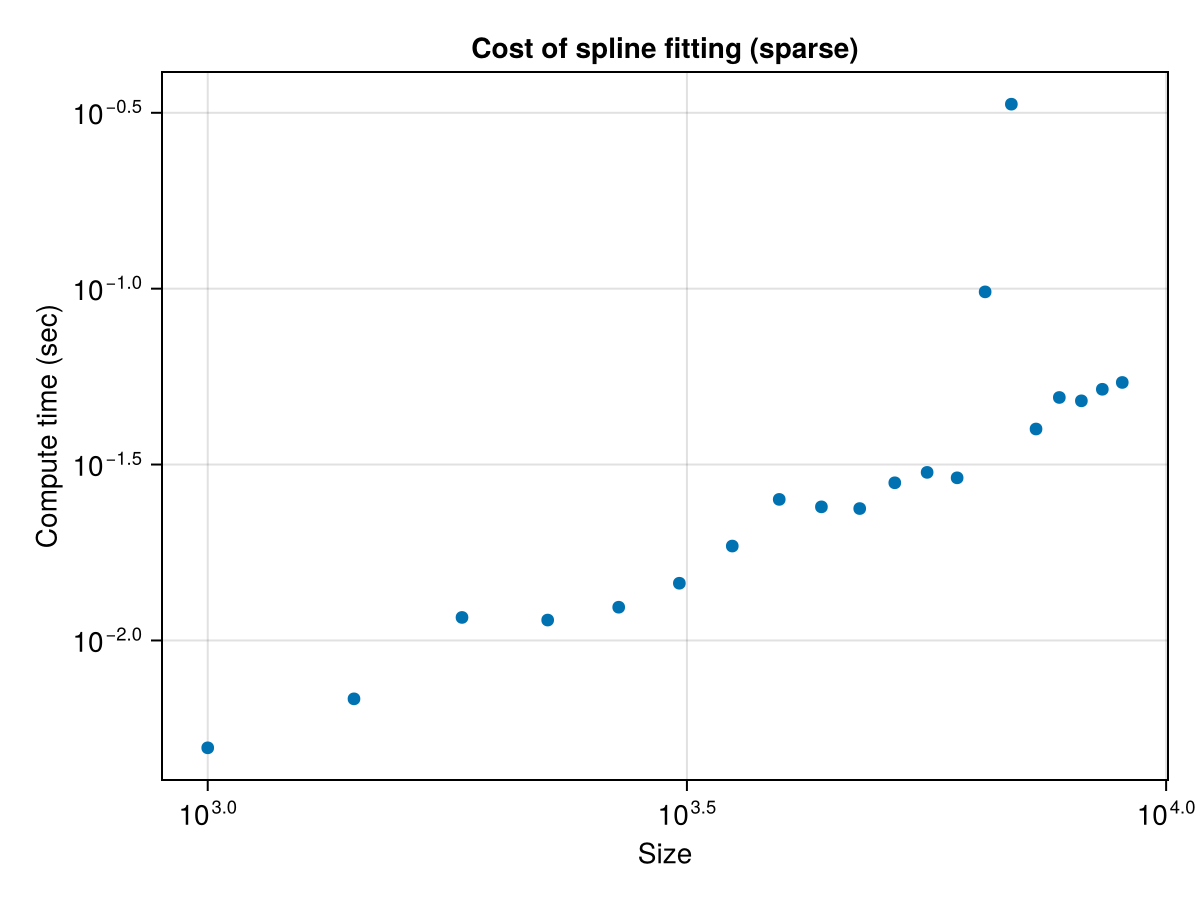

In [52]:
f = Figure()
ax = Axis(f[1,1], title="Cost of spline fitting (sparse)", xlabel="Size", ylabel="Compute time (sec)",
        yscale=log10,xscale=log10)
scatter!(sparse_sizes, sparse_times)
f

How does your sparse version perform?  Is it faster?  How about the _shape_ of the time-versus-size curve?  (You might need to use larger sizes to see this.)  If the curve looks like time is a power of size, can you estimate the power?

The power is about O(N)